# analyze casp14 mqa result

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
pd.options.display.float_format = '{:.3f}'.format
plt.rcParams["figure.dpi"] = 150
sns.set(style='darkgrid')
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# function for performance evaluation 
def get_loss(target_df, label_name, column_name):
    try:
        loss = target_df[label_name].max() - target_df[label_name][target_df[column_name].idxmax()]
    except TypeError as e:
        loss = None
    return loss

def get_whole_loss(df, label_name: str, column_list: list):
    loss_list = [get_loss(df, label_name, column) for column in column_list]
    return pd.DataFrame({label_name + ' Loss':loss_list}, index=column_list)

def get_mae(df, label_name, column_name):
    df = df.dropna(subset=[column_name])
    try:
        mae = mean_absolute_error(df[label_name], df[column_name])
    except ValueError as e:
        mae = None
    return mae

def get_whole_mae(df, label_name: str, column_list: list):
    mae_list = [get_mae(df, label_name, column) for column in column_list]
    return pd.DataFrame({label_name + ' MAE':mae_list}, index=column_list)

def get_mse(df, label_name, column_name):
    df = df.dropna(subset=[column_name])
    try:
        mse = mean_squared_error(df[label_name], df[column_name])
    except ValueError as e:
        mse = None
    return mse

def get_whole_mse(df, label_name: str, column_list: list):
    mse_list = [get_mse(df, label_name, column) for column in column_list]
    return pd.DataFrame({label_name + ' MSE':mse_list}, index=column_list)

def eval(df, columns, label_name='GDT_TS', threshold=0):
    metrics_array = []
    df = df.groupby('Target').filter(lambda x: x[label_name].max() >= threshold)
    if df[label_name].max() > 1:
        df[label_name] /= 100
    group = df.groupby('Target')
    pearson = group.corr()[label_name].loc[:, columns].rename(label_name + ' Pearson')
    spearman = group.corr(method='spearman')[label_name].loc[:, columns].rename(label_name + ' Spearman')
    loss = group.apply(lambda x: get_whole_loss(x, label_name, columns)) * 100
    mae = group.apply(lambda x: get_whole_mae(x, label_name, columns))
    mse = group.apply(lambda x: get_whole_mse(x, label_name, columns))
    performance_df = pd.concat([pearson, spearman, loss, mae, mse], axis=1).reset_index().rename(columns={'level_1': 'Group'})
    print(len(group))
    return performance_df

In [28]:
# function for visualization
def scatter(df, x='GDT_TS', y='Proposed', col_wrap=4):
    g = sns.relplot(data=df, kind='scatter', x=x, y=y, col='Target', col_wrap=col_wrap)
    g.set(xlim=(0, 100), ylim=(0, 1))
    plt.subplots_adjust(wspace=0.1)

## read mqa score

In [4]:
df = pd.read_csv('../data/casp14_stage2.csv', index_col=0)
df = df.dropna(subset=['GDT_TS'])

In [5]:
# filter targets not included in the mqa results table (T1027, T1088)
fil_target = ['T1027', 'T1088']
df_fil = df.groupby('Target').filter(lambda x: x.name not in fil_target)

In [6]:
df_fil

3DCNN_prof  ProQ3D  GraphQA  angleQA  ProQ2  DAVIS-EMAconsensus  \
T1024TS075_1       0.661   0.586    0.649    0.467  0.598               0.648   
T1024TS050_4       0.570   0.541    0.579    0.416  0.547               0.624   
T1024TS211_4       0.560   0.532    0.584    0.419  0.541               0.611   
T1024TS367_5       0.698   0.684    0.646    0.601  0.610               0.690   
T1024TS278_1       0.697   0.751    0.716    0.487  0.738               0.683   
...                  ...     ...      ...      ...    ...                 ...   
T1101TS013_5       0.677   0.653    0.719    0.708  0.791               0.518   
T1101TS031_4       0.711   0.603    0.668    0.693  0.666               0.559   
T1101TS140_5       0.690   0.624    0.704    0.762  0.676               0.574   
T1101TS435_4       0.669   0.533    0.666    0.692  0.691               0.546   
T1101TS337_4       0.652   0.580    0.689    0.620  0.662               0.516   

              BAKER-ROSETTASERVER  BAKER-experimental  P3De  ModFOLD8  ...  \
T1024TS075_1                0.678               0.618 0.568     0.582  ...   
T1024TS050_4                0.601               0.542 0.532     0.571  ...   
T1024TS211_4                0.625               0.592 0.492     0.536  ...   
T1024TS367_5                0.743               0.731 0.614     0.579  ...   
T1024TS278_1                0.727               0.668 0.703     0.557  ...   
...                           ...                 ...   ...       ...  ...   
T1101TS013_5                0.739               0.762 0.625     0.528  ...   
T1101TS031_4                0.679               0.661 0.594     0.537  ...   
T1101TS140_5                0.701               0.731 0.590     0.563  ...   
T1101TS435_4                0.629               0.604 0.549     0.507  ...   
T1101TS337_4                0.677               0.664 0.578     0.531  ...   

              TMscore  Dali(raw)  FlexE    QSE  CAD_SS  MolPrb_clash  \
T1024TS075_1    0.710   1371.200  7.200 69.890   0.340        98.170   
T1024TS050_4    0.740   3138.000  6.100 80.300   0.310       129.740   
T1024TS211_4    0.670   2840.300  4.910 64.190   0.310        69.960   
T1024TS367_5    0.850   4656.400  3.070    nan   0.440        20.080   
T1024TS278_1    0.820   4387.800  2.990 77.010   0.400         0.620   
...               ...        ...    ...    ...     ...           ...   
T1101TS013_5    0.600   1864.500  6.730 63.780   0.460         0.200   
T1101TS031_4    0.640   1853.600 11.460 74.520   0.430         0.990   
T1101TS140_5    0.750   2614.200 10.810 69.060   0.410        32.170   
T1101TS435_4    0.670   2200.700  7.530 64.720   0.350        36.880   
T1101TS337_4    0.680   2468.600 11.900 89.580   0.370       122.870   

             MolPrb_rotout  MolPrb_ramout  MolPrb_ramfv  Target  
T1024TS075_1         0.000          1.230        95.320   T1024  
T1024TS050_4         4.110          2.220        93.100   T1024  
T1024TS211_4        10.900          5.110        84.680   T1024  
T1024TS367_5         0.590          1.230        96.800   T1024  
T1024TS278_1         0.290          0.000        97.540   T1024  
...                    ...            ...           ...     ...  
T1101TS013_5         0.350          0.950        94.300   T1101  
T1101TS031_4         2.840          3.480        90.190   T1101  
T1101TS140_5         1.060          3.800        91.140   T1101  
T1101TS435_4         8.510          8.230        79.430   T1101  
T1101TS337_4         3.190          1.590        93.630   T1101  

[9869 rows x 60 columns]

## read domain definitions and classifications

In [7]:
dom_cla_df = pd.read_csv('../data/casp14_domain_definitions_and_classifications_fixed.csv', index_col=0)
# delete duplicated target (multidomain)
dom_cla_df = dom_cla_df.drop_duplicates(keep='first', subset='Target')
dom_cla_df

Target  Residues         Type                      Domains  \
#                                                                
1    T1024       408   All groups                     T1024-D0   
3    T1025       268  Server only             T1025-D1: 12-268   
4    T1026       172   All groups             T1026-D1: 27-172   
5    T1027       168   All groups  T1027-D1: 8-18,34-81,95-134   
6    T1028       316  Server only             T1028-D1: 16-307   
..     ...       ...          ...                          ...   
99   T1095       665   All groups              T1095-D1: 1-649   
100  T1096       464   All groups                     T1096-D0   
102  T1099       262   All groups             T1099-D1: 11-188   
103  T1100       338   All groups                     T1100-D0   
105  T1101       318   All groups             T1101-D0: 12-318   

     Residues in domain Classification   PDB        Domain  
#                                                           
1                   408       TBM-easy  6t1z   MultiDomain  
3                   257       TBM-easy  6uv6  SingleDomain  
4                   146       TBM-hard  6s44  SingleDomain  
5                    99             FM     -  SingleDomain  
6                   292       TBM-easy     -  SingleDomain  
..                  ...            ...   ...           ...  
99                  649       TBM-hard     -  SingleDomain  
100                 464             FM     -   MultiDomain  
102                 178       TBM-hard  6ygh  SingleDomain  
103                 338       TBM-hard     -   MultiDomain  
105                 307       TBM-easy     -   MultiDomain  

[68 rows x 8 columns]

## concat mqa df and domain df

In [8]:
cdf = pd.merge(df_fil, dom_cla_df, on='Target', how='inner')
cdf

3DCNN_prof  ProQ3D  GraphQA  angleQA  ProQ2  DAVIS-EMAconsensus  \
0          0.661   0.586    0.649    0.467  0.598               0.648   
1          0.570   0.541    0.579    0.416  0.547               0.624   
2          0.560   0.532    0.584    0.419  0.541               0.611   
3          0.698   0.684    0.646    0.601  0.610               0.690   
4          0.697   0.751    0.716    0.487  0.738               0.683   
...          ...     ...      ...      ...    ...                 ...   
9864       0.677   0.653    0.719    0.708  0.791               0.518   
9865       0.711   0.603    0.668    0.693  0.666               0.559   
9866       0.690   0.624    0.704    0.762  0.676               0.574   
9867       0.669   0.533    0.666    0.692  0.691               0.546   
9868       0.652   0.580    0.689    0.620  0.662               0.516   

      BAKER-ROSETTASERVER  BAKER-experimental  P3De  ModFOLD8  ...  \
0                   0.678               0.618 0.568     0.582  ...   
1                   0.601               0.542 0.532     0.571  ...   
2                   0.625               0.592 0.492     0.536  ...   
3                   0.743               0.731 0.614     0.579  ...   
4                   0.727               0.668 0.703     0.557  ...   
...                   ...                 ...   ...       ...  ...   
9864                0.739               0.762 0.625     0.528  ...   
9865                0.679               0.661 0.594     0.537  ...   
9866                0.701               0.731 0.590     0.563  ...   
9867                0.629               0.604 0.549     0.507  ...   
9868                0.677               0.664 0.578     0.531  ...   

      MolPrb_ramout  MolPrb_ramfv  Target  Residues        Type  \
0             1.230        95.320   T1024       408  All groups   
1             2.220        93.100   T1024       408  All groups   
2             5.110        84.680   T1024       408  All groups   
3             1.230        96.800   T1024       408  All groups   
4             0.000        97.540   T1024       408  All groups   
...             ...           ...     ...       ...         ...   
9864          0.950        94.300   T1101       318  All groups   
9865          3.480        90.190   T1101       318  All groups   
9866          3.800        91.140   T1101       318  All groups   
9867          8.230        79.430   T1101       318  All groups   
9868          1.590        93.630   T1101       318  All groups   

               Domains Residues in domain  Classification   PDB       Domain  
0             T1024-D0                408        TBM-easy  6t1z  MultiDomain  
1             T1024-D0                408        TBM-easy  6t1z  MultiDomain  
2             T1024-D0                408        TBM-easy  6t1z  MultiDomain  
3             T1024-D0                408        TBM-easy  6t1z  MultiDomain  
4             T1024-D0                408        TBM-easy  6t1z  MultiDomain  
...                ...                ...             ...   ...          ...  
9864  T1101-D0: 12-318                307        TBM-easy     -  MultiDomain  
9865  T1101-D0: 12-318                307        TBM-easy     -  MultiDomain  
9866  T1101-D0: 12-318                307        TBM-easy     -  MultiDomain  
9867  T1101-D0: 12-318                307        TBM-easy     -  MultiDomain  
9868  T1101-D0: 12-318                307        TBM-easy     -  MultiDomain  

[9869 rows x 67 columns]

## performance evaluation

In [9]:
df.columns

Index(['3DCNN_prof', 'ProQ3D', 'GraphQA', 'angleQA', 'ProQ2',
       'DAVIS-EMAconsensus', 'BAKER-ROSETTASERVER', 'BAKER-experimental',
       'P3De', 'ModFOLD8', 'tFold-IDT', 'VoroCNN-GDT', 'VoroCNN-GEMME',
       'DeepPotential', 'Ornate', 'SBROD', 'GR#', 'GDT_TS', 'NP_P', 'RANK',
       'Z-M1-GDT', 'Z-MA-GDT', 'GDT_HA', 'GDC_SC', 'GDC_ALL', 'RMS_CA',
       'RMS_ALL', 'NP', 'err', 'AL0_P', 'AL4_P', 'ALI_P', 'LGA_S', 'RMSD[L]',
       'Z-score[M]', 'Z-Score[D]', 'Al.Res.', 'RMSD[D]', 'MolPrb_Score',
       'LDDT', 'SphGr', 'CAD_AA', 'RPF', 'CODM', 'DFM', 'Handed.', 'SOV', 'CE',
       'QCS', 'CONTS', 'TMscore', 'Dali(raw)', 'FlexE', 'QSE', 'CAD_SS',
       'MolPrb_clash', 'MolPrb_rotout', 'MolPrb_ramout', 'MolPrb_ramfv',
       'Target'],
      dtype='object')

In [10]:
single_model_list = ['3DCNN_prof', 'ProQ3D', 'GraphQA', 'angleQA', 'ProQ2',
       'DAVIS-EMAconsensus', 'BAKER-ROSETTASERVER', 'BAKER-experimental',
       'P3De', 'ModFOLD8', 'tFold-IDT', 'VoroCNN-GDT', 'VoroCNN-GEMME',
       'DeepPotential', 'Ornate', 'SBROD', 'LDDT']

In [11]:
eval_df = eval(df_fil, columns=single_model_list, threshold=40)
eval_df.groupby('Group').mean().reset_index()

58


Group  GDT_TS Pearson  GDT_TS Spearman  GDT_TS Loss  \
0            3DCNN_prof           0.598            0.560       10.479   
1   BAKER-ROSETTASERVER           0.662            0.613        8.333   
2    BAKER-experimental           0.623            0.589        8.378   
3    DAVIS-EMAconsensus           0.763            0.695        9.104   
4         DeepPotential           0.589            0.497       11.848   
5               GraphQA           0.521            0.481        9.815   
6                  LDDT           0.780            0.784        2.121   
7              ModFOLD8           0.649            0.602        8.496   
8                Ornate           0.550            0.515       12.236   
9                  P3De           0.560            0.516       10.644   
10                ProQ2           0.487            0.452       10.984   
11               ProQ3D           0.544            0.503       10.766   
12                SBROD           0.500            0.447       10.887   
13          VoroCNN-GDT           0.557            0.508        9.706   
14        VoroCNN-GEMME           0.536            0.488       10.560   
15              angleQA           0.482            0.423       14.012   
16            tFold-IDT           0.516            0.490       10.758   

    GDT_TS MAE  GDT_TS MSE  
0        0.149       0.034  
1        0.117       0.023  
2        0.122       0.025  
3        0.070       0.011  
4        0.117       0.027  
5        0.135       0.030  
6        0.099       0.014  
7        0.140       0.032  
8        0.158       0.036  
9        0.120       0.023  
10       0.138       0.032  
11       0.130       0.025  
12       0.207       0.067  
13       0.157       0.034  
14       0.150       0.032  
15       0.133       0.028  
16       0.216       0.071

In [12]:
eval_df.groupby('Group').mean().sort_values('GDT_TS Loss')

GDT_TS Pearson  GDT_TS Spearman  GDT_TS Loss  GDT_TS MAE  \
Group                                                                           
LDDT                          0.780            0.784        2.121       0.099   
BAKER-ROSETTASERVER           0.662            0.613        8.333       0.117   
BAKER-experimental            0.623            0.589        8.378       0.122   
ModFOLD8                      0.649            0.602        8.496       0.140   
DAVIS-EMAconsensus            0.763            0.695        9.104       0.070   
VoroCNN-GDT                   0.557            0.508        9.706       0.157   
GraphQA                       0.521            0.481        9.815       0.135   
3DCNN_prof                    0.598            0.560       10.479       0.149   
VoroCNN-GEMME                 0.536            0.488       10.560       0.150   
P3De                          0.560            0.516       10.644       0.120   
tFold-IDT                     0.516            0.490       10.758       0.216   
ProQ3D                        0.544            0.503       10.766       0.130   
SBROD                         0.500            0.447       10.887       0.207   
ProQ2                         0.487            0.452       10.984       0.138   
DeepPotential                 0.589            0.497       11.848       0.117   
Ornate                        0.550            0.515       12.236       0.158   
angleQA                       0.482            0.423       14.012       0.133   

                     GDT_TS MSE  
Group                            
LDDT                      0.014  
BAKER-ROSETTASERVER       0.023  
BAKER-experimental        0.025  
ModFOLD8                  0.032  
DAVIS-EMAconsensus        0.011  
VoroCNN-GDT               0.034  
GraphQA                   0.030  
3DCNN_prof                0.034  
VoroCNN-GEMME             0.032  
P3De                      0.023  
tFold-IDT                 0.071  
ProQ3D                    0.025  
SBROD                     0.067  
ProQ2                     0.032  
DeepPotential             0.027  
Ornate                    0.036  
angleQA                   0.028

In [13]:
eval_df

Target          Group  GDT_TS Pearson  GDT_TS Spearman  GDT_TS Loss  \
0    T1024     3DCNN_prof           0.631            0.628        3.650   
1    T1024         ProQ3D           0.753            0.648        3.770   
2    T1024        GraphQA           0.738            0.573        4.410   
3    T1024        angleQA           0.738            0.738        5.120   
4    T1024          ProQ2           0.660            0.597        3.770   
..     ...            ...             ...              ...          ...   
981  T1101  VoroCNN-GEMME           0.322            0.356        1.180   
982  T1101  DeepPotential           0.133            0.102       10.690   
983  T1101         Ornate           0.235            0.249        1.180   
984  T1101          SBROD           0.291            0.301        3.450   
985  T1101           LDDT           0.607            0.583        3.120   

     GDT_TS MAE  GDT_TS MSE  
0         0.090       0.010  
1         0.087       0.010  
2         0.120       0.016  
3         0.071       0.007  
4         0.082       0.009  
..          ...         ...  
981       0.088       0.010  
982       0.194       0.041  
983       0.047       0.003  
984       0.203       0.047  
985       0.114       0.015  

[986 rows x 7 columns]

In [14]:
ceval_df = pd.merge(eval_df, dom_cla_df, on='Target', how='inner')

In [15]:
ceval_df

Target          Group  GDT_TS Pearson  GDT_TS Spearman  GDT_TS Loss  \
0    T1024     3DCNN_prof           0.631            0.628        3.650   
1    T1024         ProQ3D           0.753            0.648        3.770   
2    T1024        GraphQA           0.738            0.573        4.410   
3    T1024        angleQA           0.738            0.738        5.120   
4    T1024          ProQ2           0.660            0.597        3.770   
..     ...            ...             ...              ...          ...   
981  T1101  VoroCNN-GEMME           0.322            0.356        1.180   
982  T1101  DeepPotential           0.133            0.102       10.690   
983  T1101         Ornate           0.235            0.249        1.180   
984  T1101          SBROD           0.291            0.301        3.450   
985  T1101           LDDT           0.607            0.583        3.120   

     GDT_TS MAE  GDT_TS MSE  Residues        Type           Domains  \
0         0.090       0.010       408  All groups          T1024-D0   
1         0.087       0.010       408  All groups          T1024-D0   
2         0.120       0.016       408  All groups          T1024-D0   
3         0.071       0.007       408  All groups          T1024-D0   
4         0.082       0.009       408  All groups          T1024-D0   
..          ...         ...       ...         ...               ...   
981       0.088       0.010       318  All groups  T1101-D0: 12-318   
982       0.194       0.041       318  All groups  T1101-D0: 12-318   
983       0.047       0.003       318  All groups  T1101-D0: 12-318   
984       0.203       0.047       318  All groups  T1101-D0: 12-318   
985       0.114       0.015       318  All groups  T1101-D0: 12-318   

     Residues in domain Classification   PDB       Domain  
0                   408       TBM-easy  6t1z  MultiDomain  
1                   408       TBM-easy  6t1z  MultiDomain  
2                   408       TBM-easy  6t1z  MultiDomain  
3                   408       TBM-easy  6t1z  MultiDomain  
4                   408       TBM-easy  6t1z  MultiDomain  
..                  ...            ...   ...          ...  
981                 307       TBM-easy     -  MultiDomain  
982                 307       TBM-easy     -  MultiDomain  
983                 307       TBM-easy     -  MultiDomain  
984                 307       TBM-easy     -  MultiDomain  
985                 307       TBM-easy     -  MultiDomain  

[986 rows x 14 columns]

In [16]:
# boxplot and swarmplot for each group
def plot_metrics_group(df, metrics, hue=None, figsize=(10, 8), pointsize=4):
    plt.figure(figsize=figsize)
    sns.boxplot(data=df, x=metrics, y='Group', orient='h', color='white')
    sns.swarmplot(data=df, x=metrics, y='Group', orient='h', hue=hue, size=pointsize, palette='Set2')
    plt.tight_layout()

### GDT_TS loss for each group

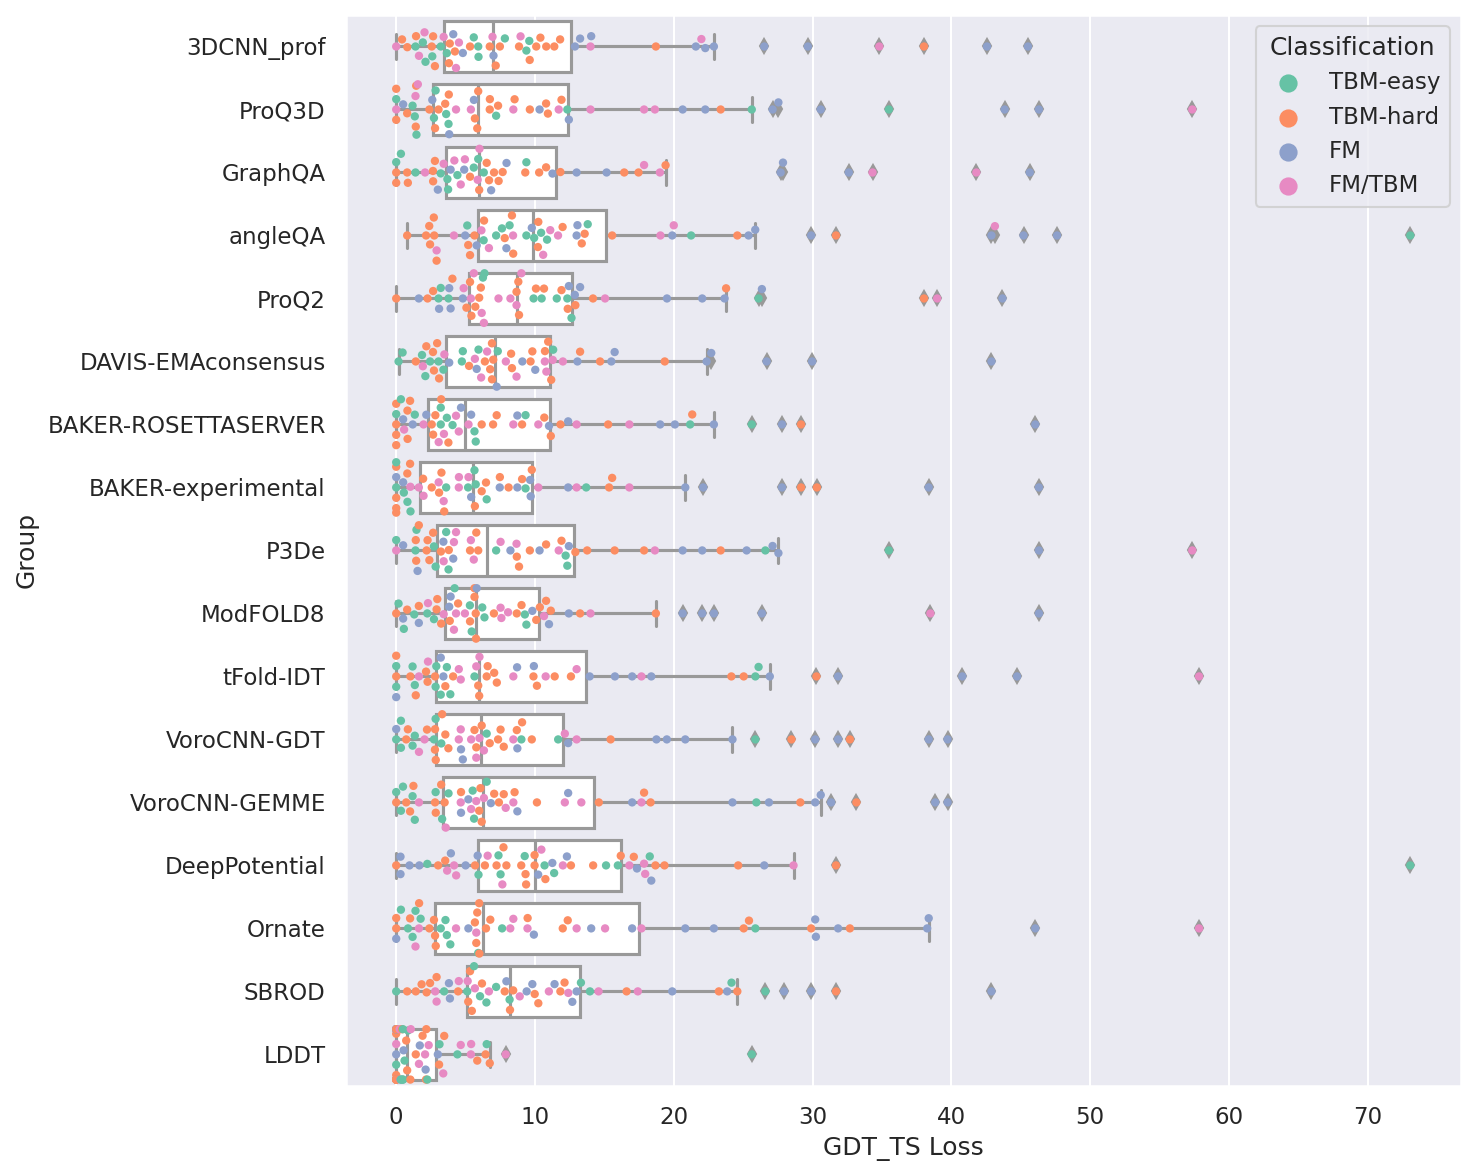

In [19]:
metrics = 'GDT_TS Loss'
hue = 'Classification'
plot_metrics_group(ceval_df, metrics, hue)
plt.savefig('../data/plot/casp14_gdtts_loss_boxplot_class.png')

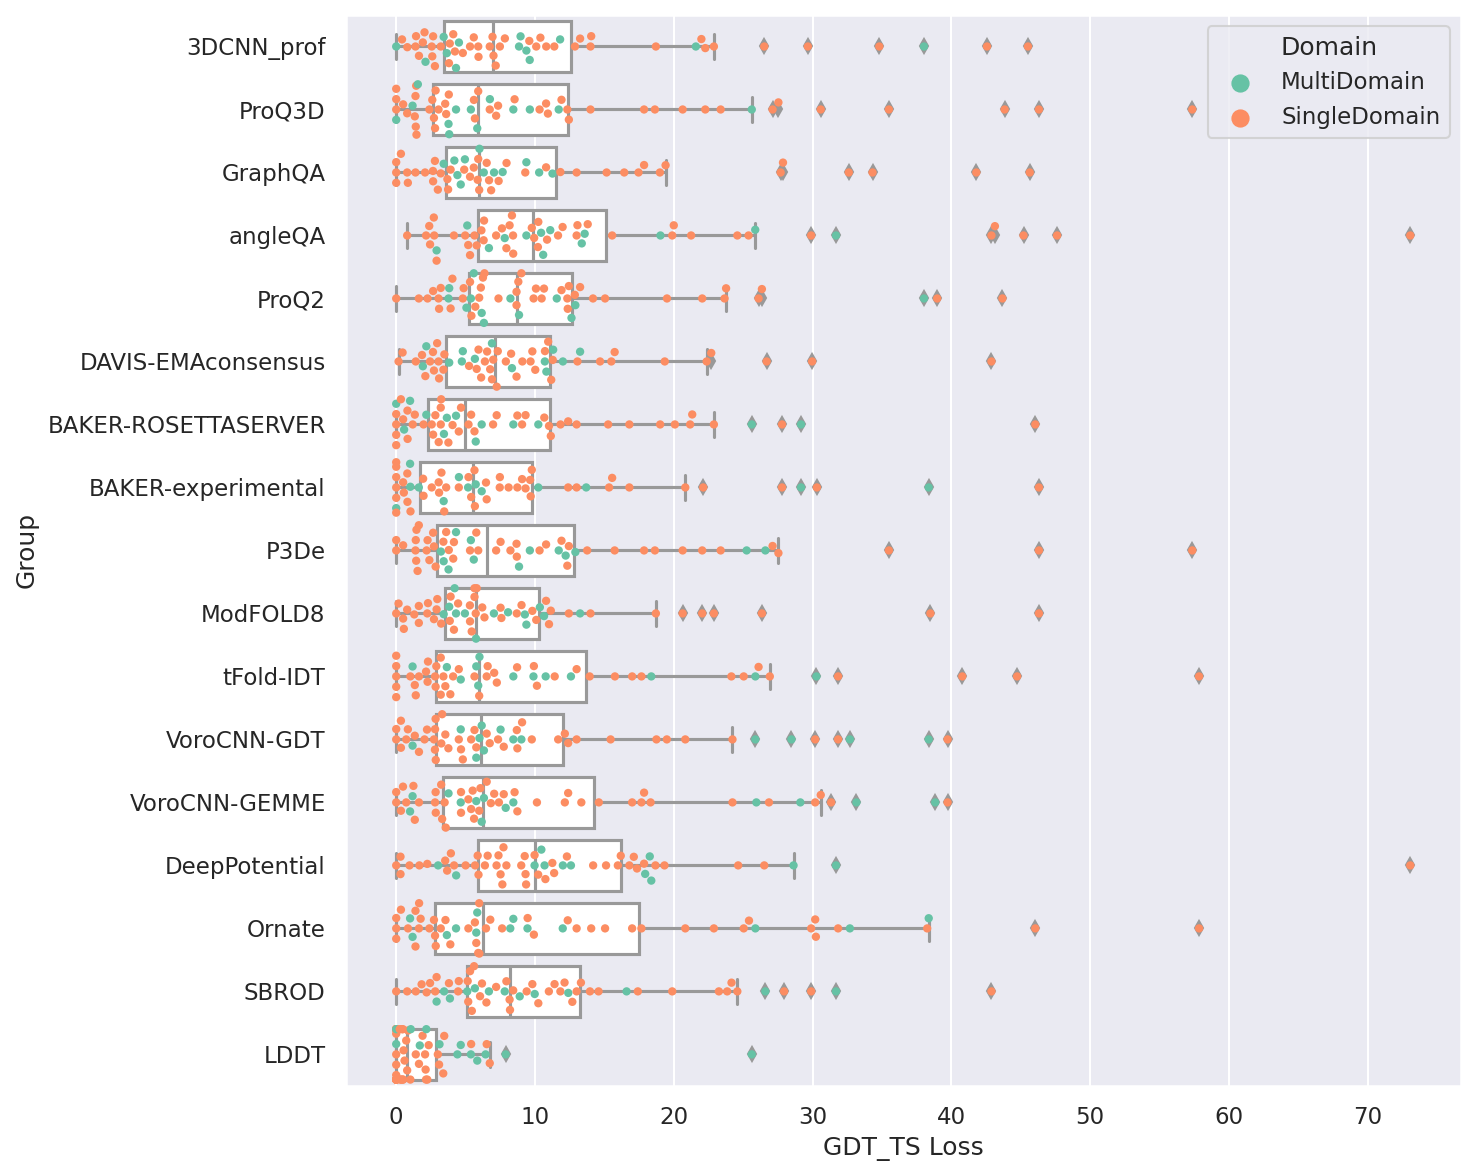

In [20]:
metrics = 'GDT_TS Loss'
hue = 'Domain'
plot_metrics_group(ceval_df, metrics=metrics, hue=hue)
plt.savefig('../data/plot/casp14_gdtts_loss_boxplot_domain.png')

### Pearson for each group

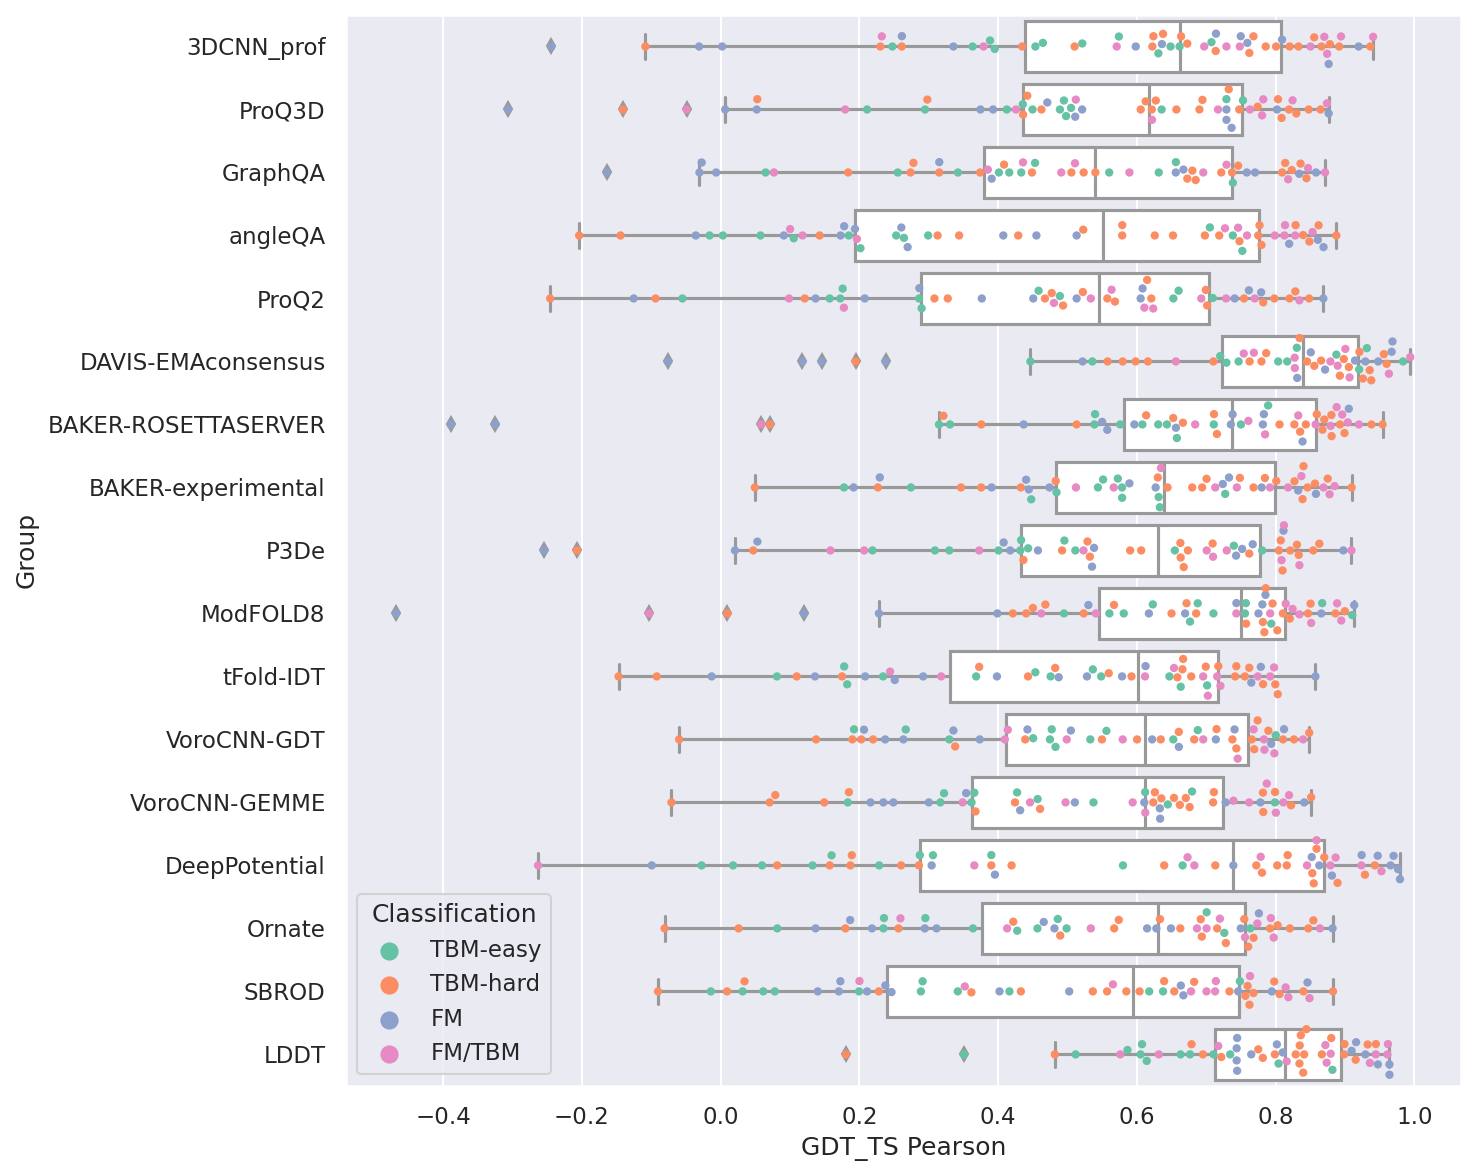

In [21]:
metrics = 'GDT_TS Pearson'
hue = 'Classification'
plot_metrics_group(ceval_df, metrics, hue)
plt.savefig('../data/plot/casp14_gdtts_pearson_boxplot_class.png')

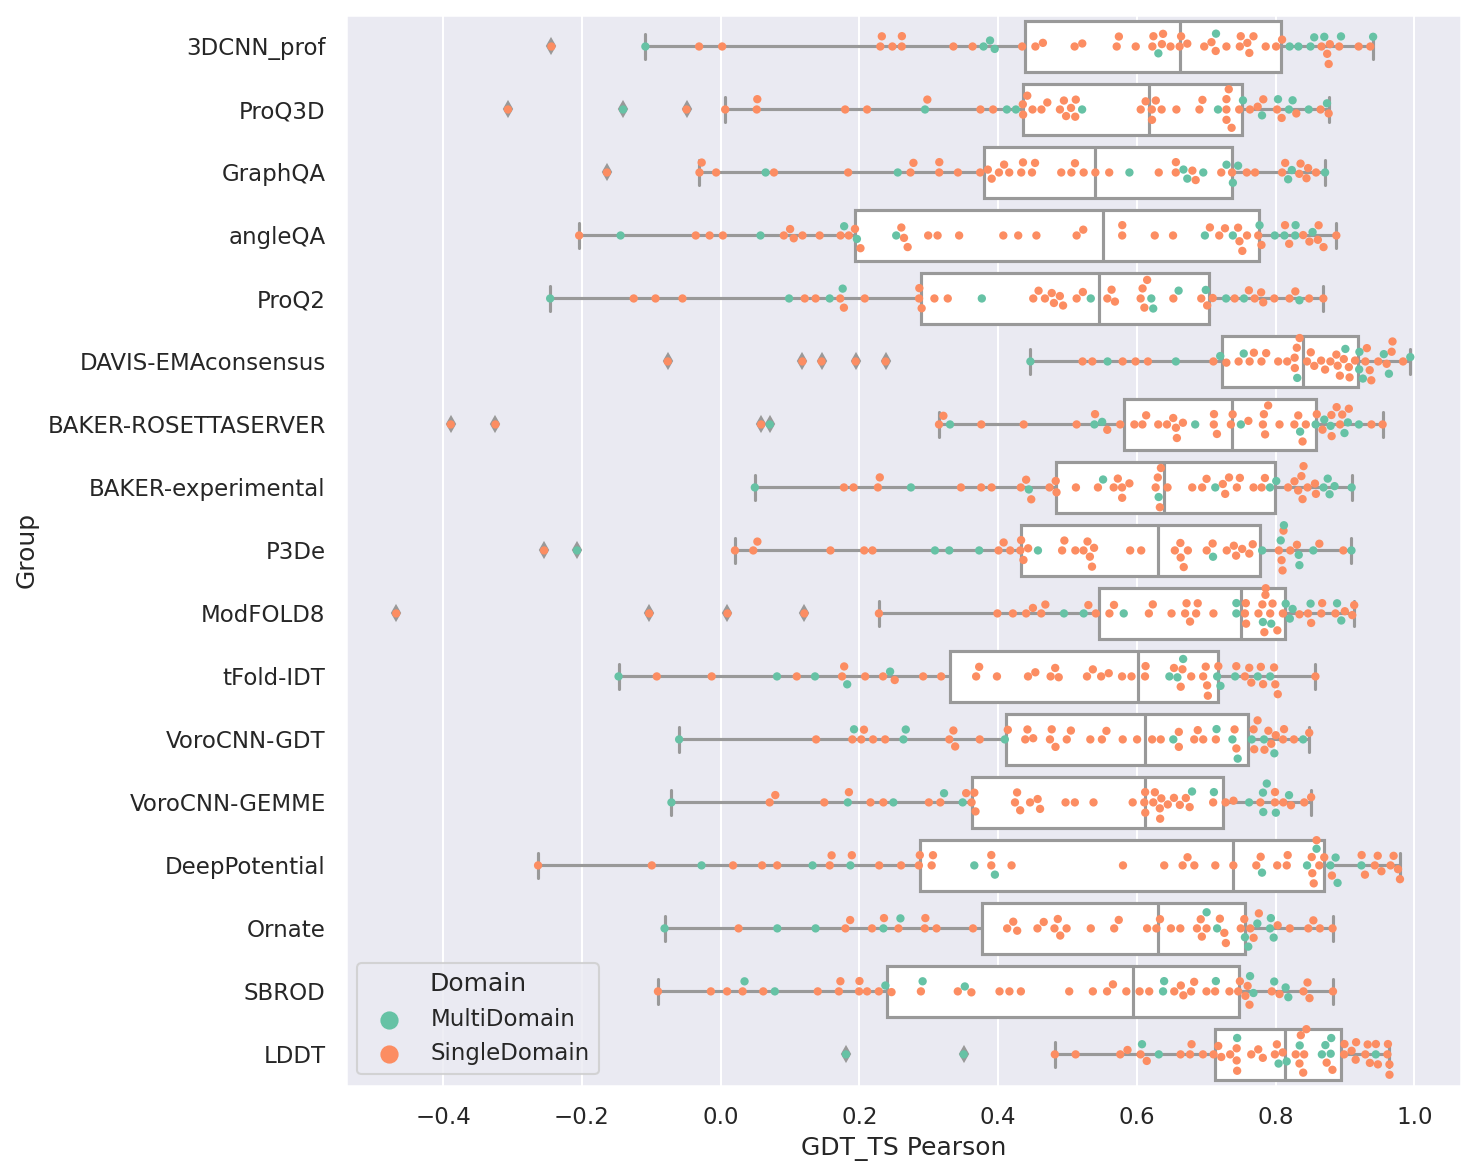

In [22]:
metrics = 'GDT_TS Pearson'
hue = 'Domain'
plot_metrics_group(ceval_df, metrics, hue)
plt.savefig('../data/plot/casp14_gdtts_pearson_boxplot_domain.png')

### MAE for each group

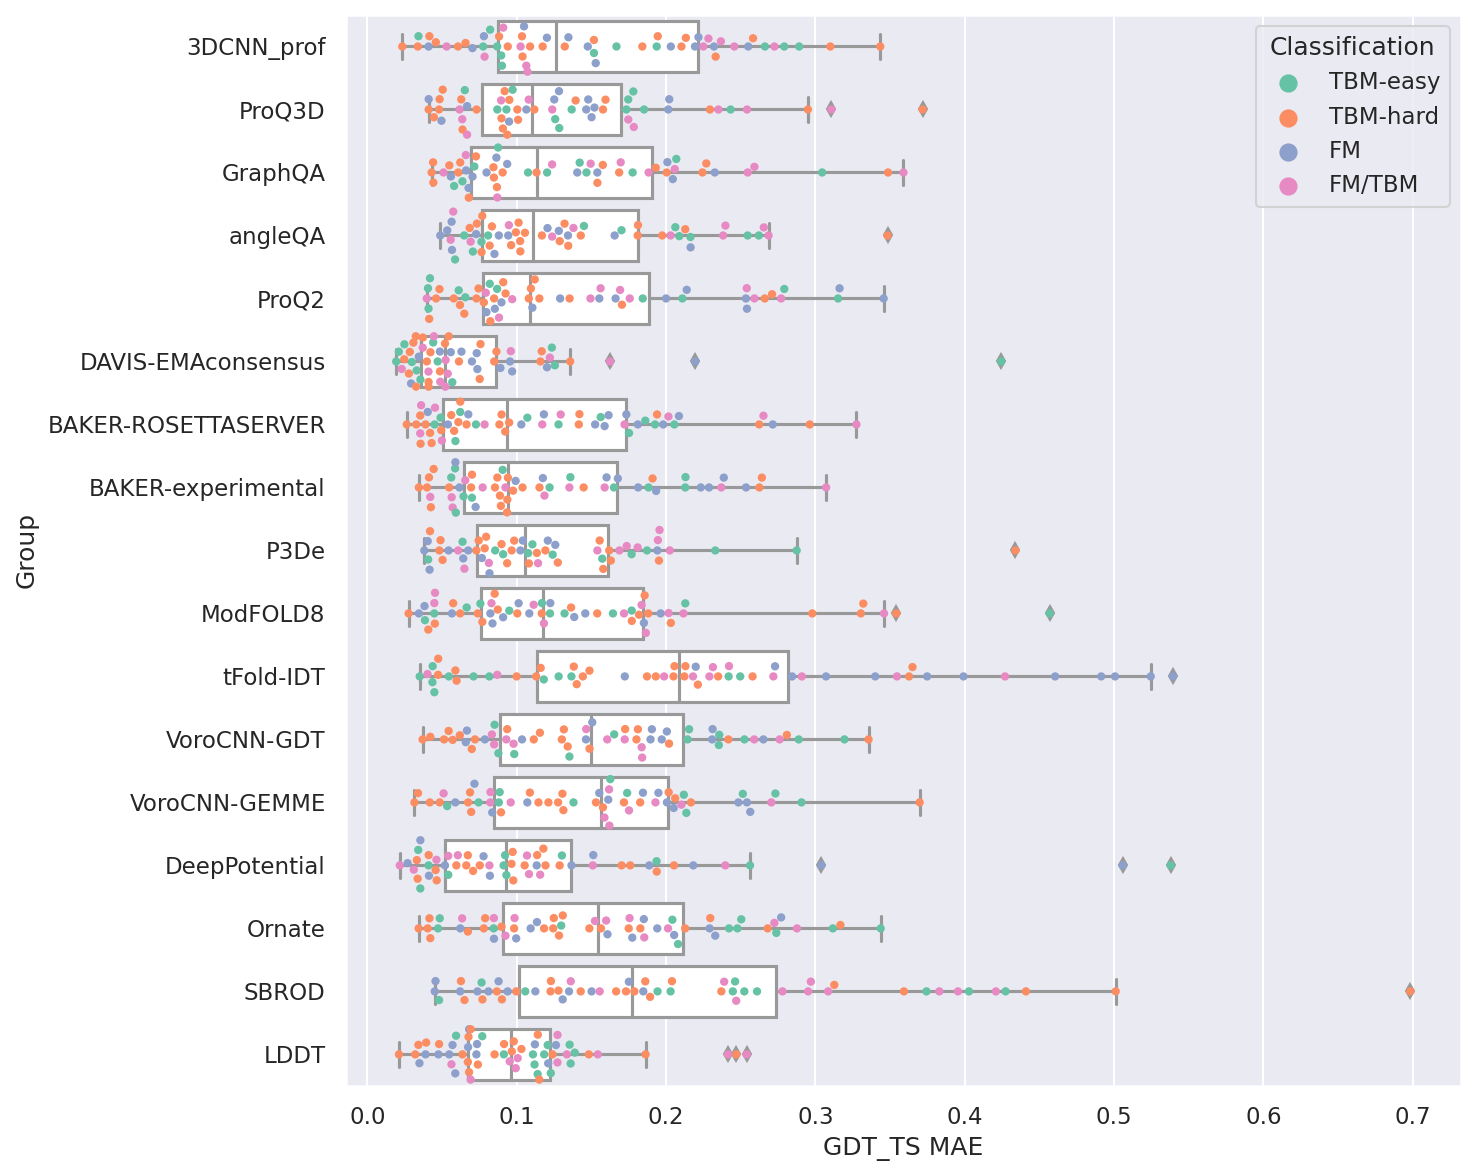

In [23]:
metrics = 'GDT_TS MAE'
hue = 'Classification'
plot_metrics_group(ceval_df, metrics, hue)
plt.savefig('../data/plot/casp14_gdtts_mae_boxplot_class.png')

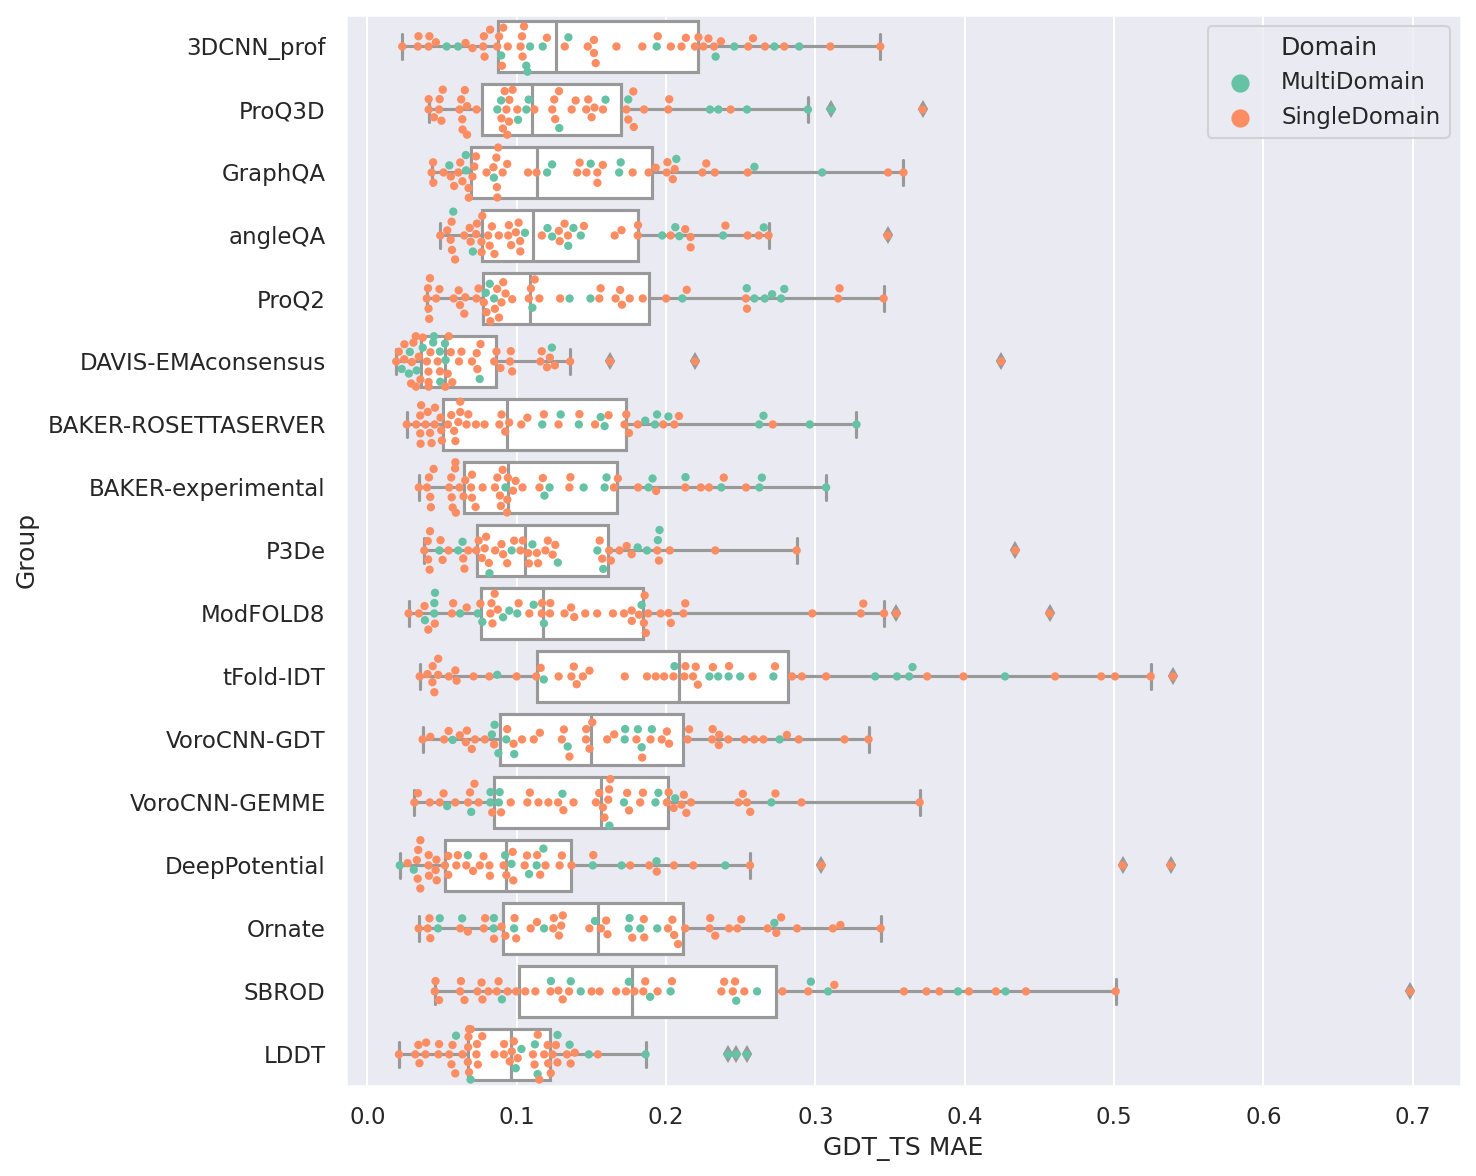

In [24]:
metrics = 'GDT_TS MAE'
hue = 'Domain'
plot_metrics_group(ceval_df, metrics, hue)
plt.savefig('../data/plot/casp14_mae_pearson_boxplot_domain.png')

### correlation between each group

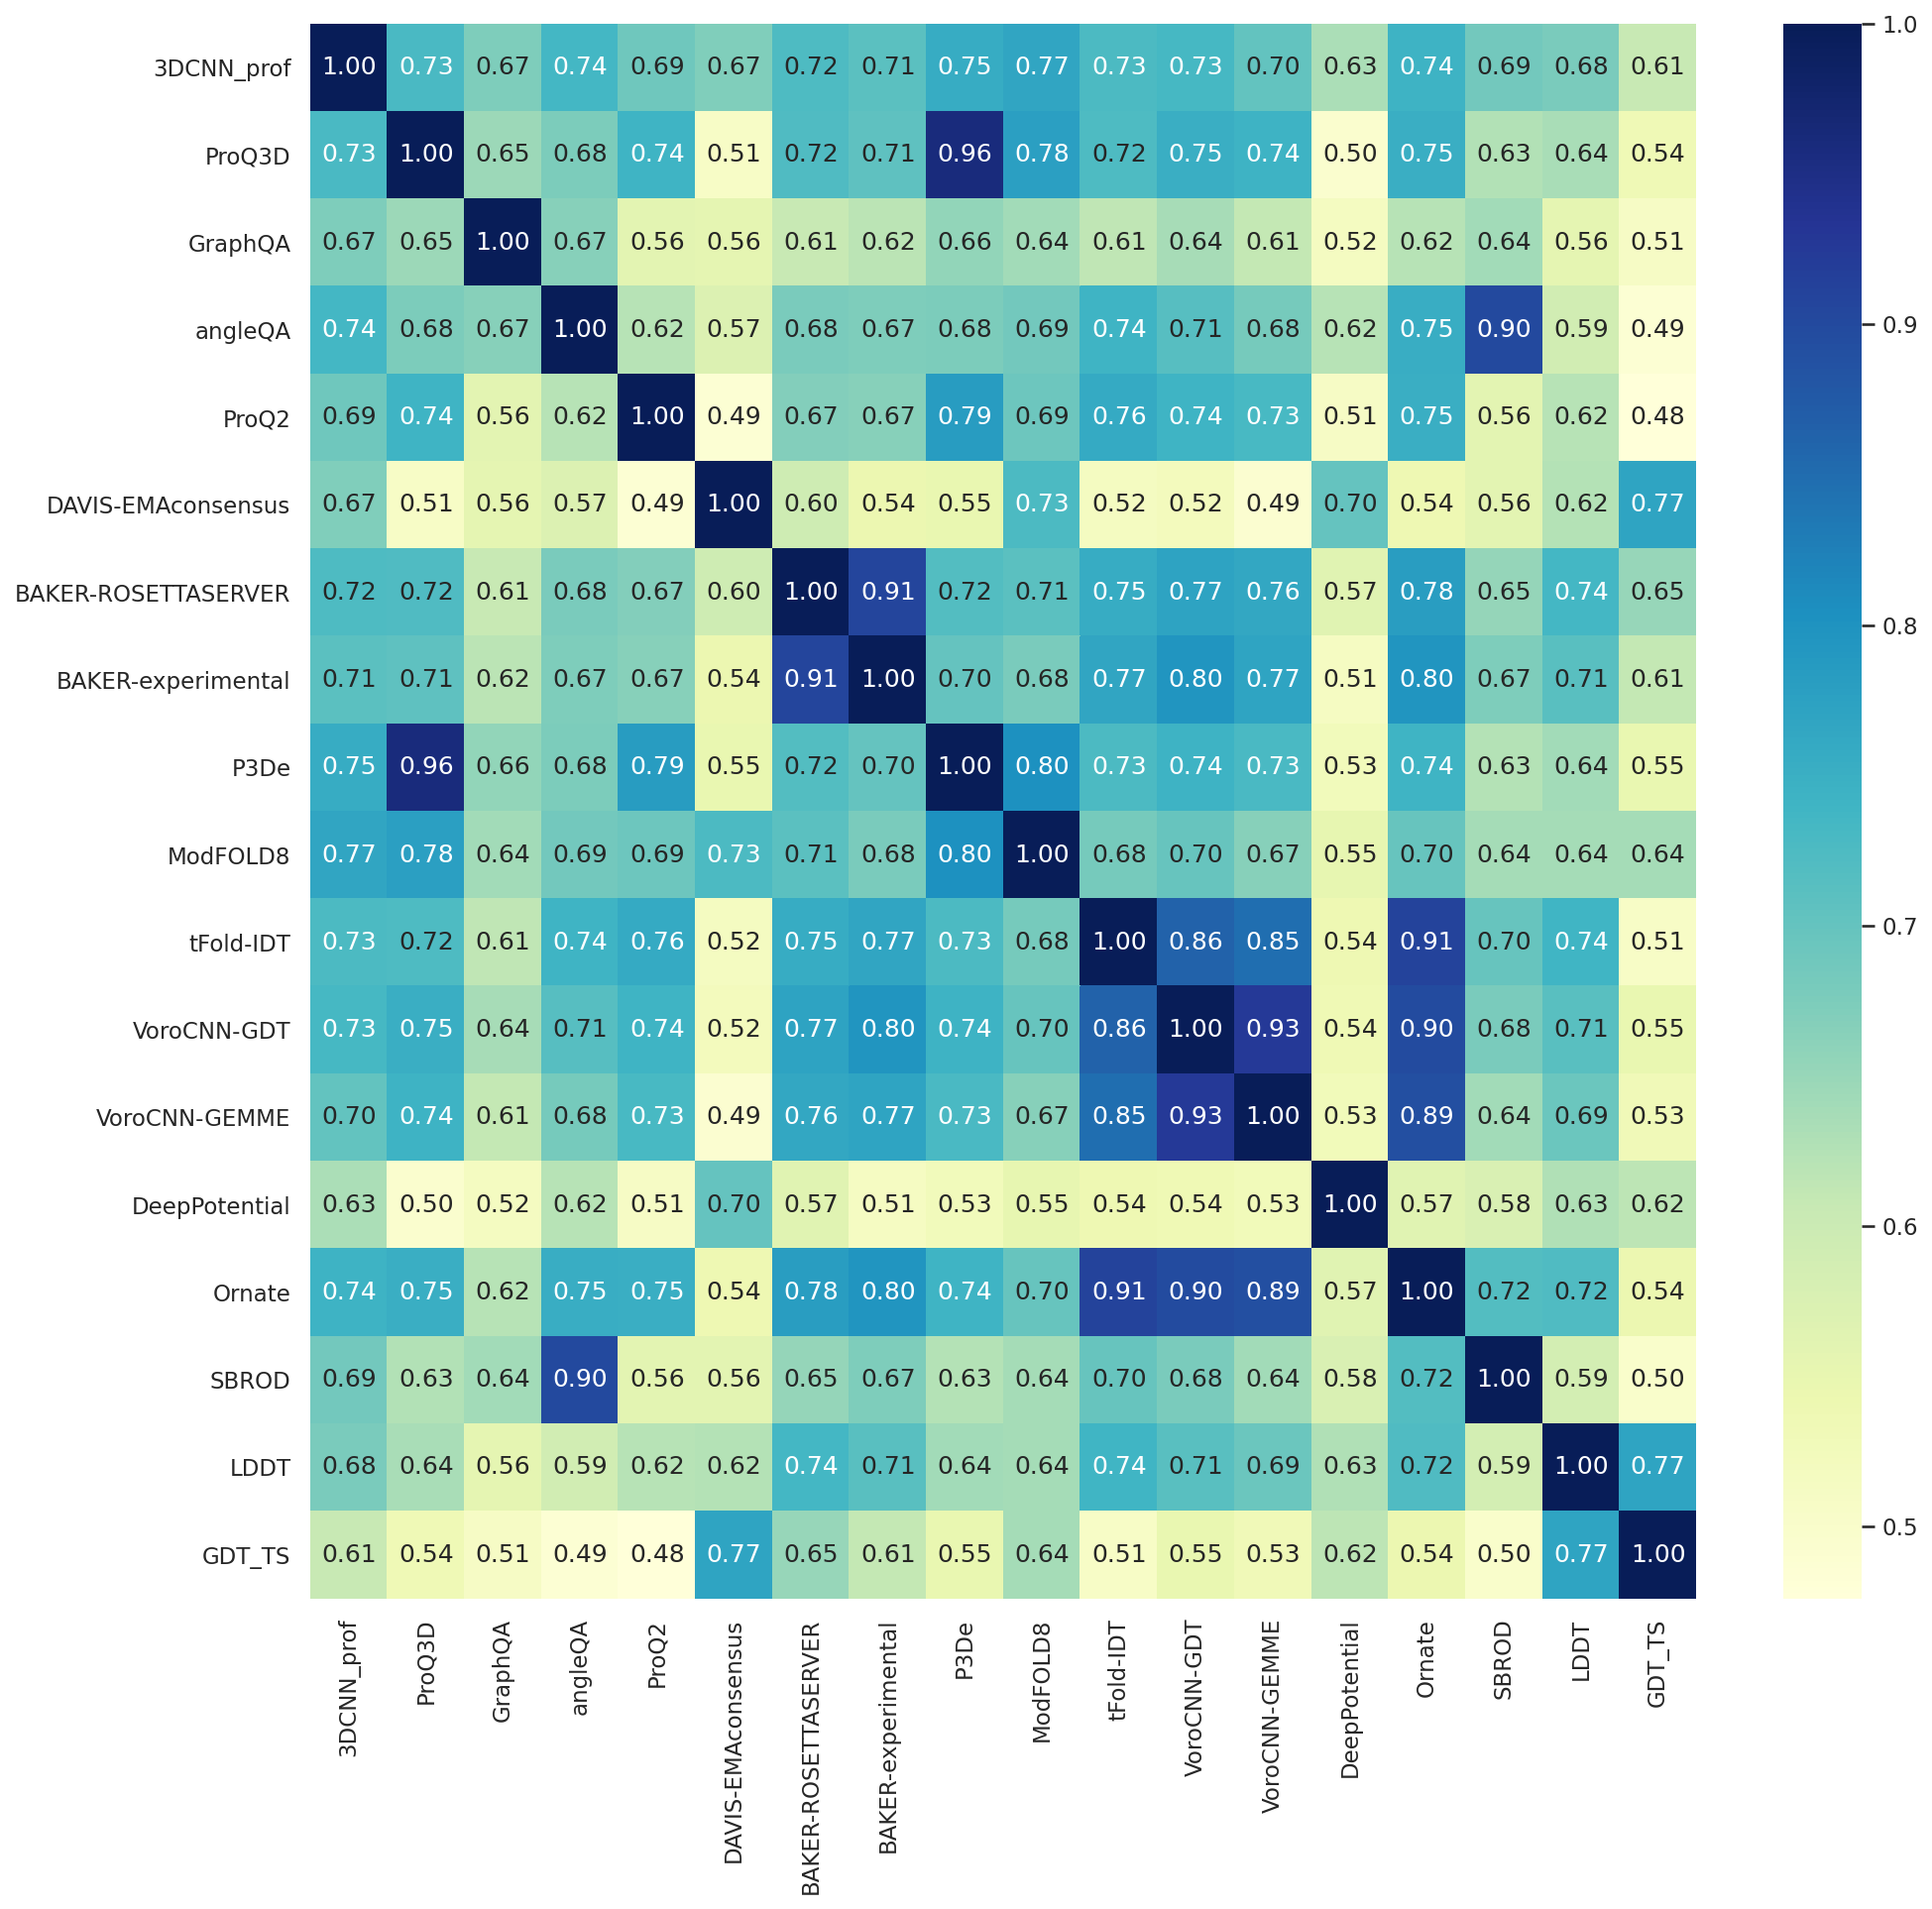

In [25]:
plt.figure(figsize=(14, 13))
sns.heatmap(df[single_model_list + ['GDT_TS', 'Target']].groupby('Target').corr().mean(level=1), cmap='YlGnBu', annot=True, fmt='.2f')
plt.tight_layout()
plt.savefig('../data/plot/casp14_mean_correlation_group.png')

# analyze 3DCNN_prof

In [24]:
df.groupby('Target').groups.keys()

dict_keys(['T1024', 'T1025', 'T1026', 'T1027', 'T1028', 'T1029', 'T1030', 'T1031', 'T1032', 'T1033', 'T1034', 'T1035', 'T1036s1', 'T1037', 'T1038', 'T1039', 'T1040', 'T1041', 'T1042', 'T1043', 'T1045s1', 'T1045s2', 'T1046s1', 'T1046s2', 'T1047s1', 'T1047s2', 'T1049', 'T1050', 'T1052', 'T1053', 'T1054', 'T1055', 'T1056', 'T1057', 'T1058', 'T1060s2', 'T1060s3', 'T1061', 'T1064', 'T1065s1', 'T1065s2', 'T1067', 'T1068', 'T1070', 'T1073', 'T1074', 'T1076', 'T1078', 'T1079', 'T1080', 'T1082', 'T1083', 'T1084', 'T1085', 'T1086', 'T1087', 'T1088', 'T1089', 'T1090', 'T1091', 'T1092', 'T1093', 'T1094', 'T1095', 'T1096', 'T1099', 'T1100', 'T1101'])

In [25]:
df.query('Target == "T1098"').sort_index()['GDT_TS']

Series([], Name: GDT_TS, dtype: float64)

In [26]:
ceval_df.query('Group=="3DCNN_prof"').sort_values('GDT_TS Pearson', ascending=True)

Target       Group  GDT_TS Pearson  GDT_TS Spearman  GDT_TS Loss  \
102    T1031  3DCNN_prof          -0.244           -0.186       45.520   
884    T1092  3DCNN_prof          -0.108           -0.159       38.030   
136    T1033  3DCNN_prof          -0.031            0.048       13.250   
289    T1043  3DCNN_prof           0.002            0.270       26.520   
918    T1095  3DCNN_prof           0.230            0.228        3.860   
170    T1035  3DCNN_prof           0.232            0.203       34.810   
850    T1089  3DCNN_prof           0.248            0.294        7.830   
833    T1087  3DCNN_prof           0.261            0.452        0.800   
221    T1039  3DCNN_prof           0.261            0.385       29.660   
238    T1040  3DCNN_prof           0.336            0.348       22.890   
17     T1025  3DCNN_prof           0.363            0.257        3.210   
425    T1052  3DCNN_prof           0.379            0.374        3.420   
408    T1050  3DCNN_prof           0.388            0.409        9.380   
969    T1101  3DCNN_prof           0.395            0.514        2.110   
935    T1099  3DCNN_prof           0.435            0.447       10.810   
306  T1045s1  3DCNN_prof           0.454            0.473        2.600   
680    T1076  3DCNN_prof           0.465            0.547        1.390   
782    T1084  3DCNN_prof           0.510            0.486        4.230   
153    T1034  3DCNN_prof           0.521            0.601        1.920   
731    T1080  3DCNN_prof           0.571            0.604       21.990   
187  T1036s1  3DCNN_prof           0.574            0.293        5.910   
272    T1042  3DCNN_prof           0.598            0.571       42.570   
765    T1083  3DCNN_prof           0.622            0.547        3.800   
493    T1056  3DCNN_prof           0.624            0.657       11.390   
0      T1024  3DCNN_prof           0.631            0.628        3.650   
663    T1074  3DCNN_prof           0.636            0.625       12.880   
544  T1060s2  3DCNN_prof           0.638            0.608        6.740   
646    T1073  3DCNN_prof           0.649            0.205        5.930   
510    T1057  3DCNN_prof           0.662            0.596        5.590   
34     T1026  3DCNN_prof           0.664            0.592        2.560   
357  T1046s2  3DCNN_prof           0.673            0.584        5.320   
748    T1082  3DCNN_prof           0.697            0.726       14.000   
51     T1028  3DCNN_prof           0.708            0.696        9.590   
612    T1067  3DCNN_prof           0.714            0.693        7.470   
901    T1094  3DCNN_prof           0.714            0.728       21.590   
340  T1046s1  3DCNN_prof           0.729            0.671        6.940   
595  T1065s2  3DCNN_prof           0.748            0.557        2.040   
255    T1041  3DCNN_prof           0.750            0.720       14.050   
68     T1029  3DCNN_prof           0.759            0.486        4.800   
459    T1054  3DCNN_prof           0.762            0.619       18.710   
119    T1032  3DCNN_prof           0.768            0.808        2.790   
629    T1068  3DCNN_prof           0.786            0.787        2.660   
714    T1079  3DCNN_prof           0.801            0.764       10.090   
204    T1037  3DCNN_prof           0.809            0.763       22.270   
816    T1086  3DCNN_prof           0.820            0.866        8.850   
85     T1030  3DCNN_prof           0.833            0.807        9.620   
374  T1047s2  3DCNN_prof           0.850            0.656        8.960   
952    T1100  3DCNN_prof           0.856            0.833       11.810   
323  T1045s2  3DCNN_prof           0.866            0.684       10.390   
799    T1085  3DCNN_prof           0.870            0.915        0.000   
476    T1055  3DCNN_prof           0.874            0.857        1.640   
391    T1049  3DCNN_prof           0.877            0.656        4.110   
578  T1065s1  3DCNN_prof           0.878            0.788        0.420   
561  T1060

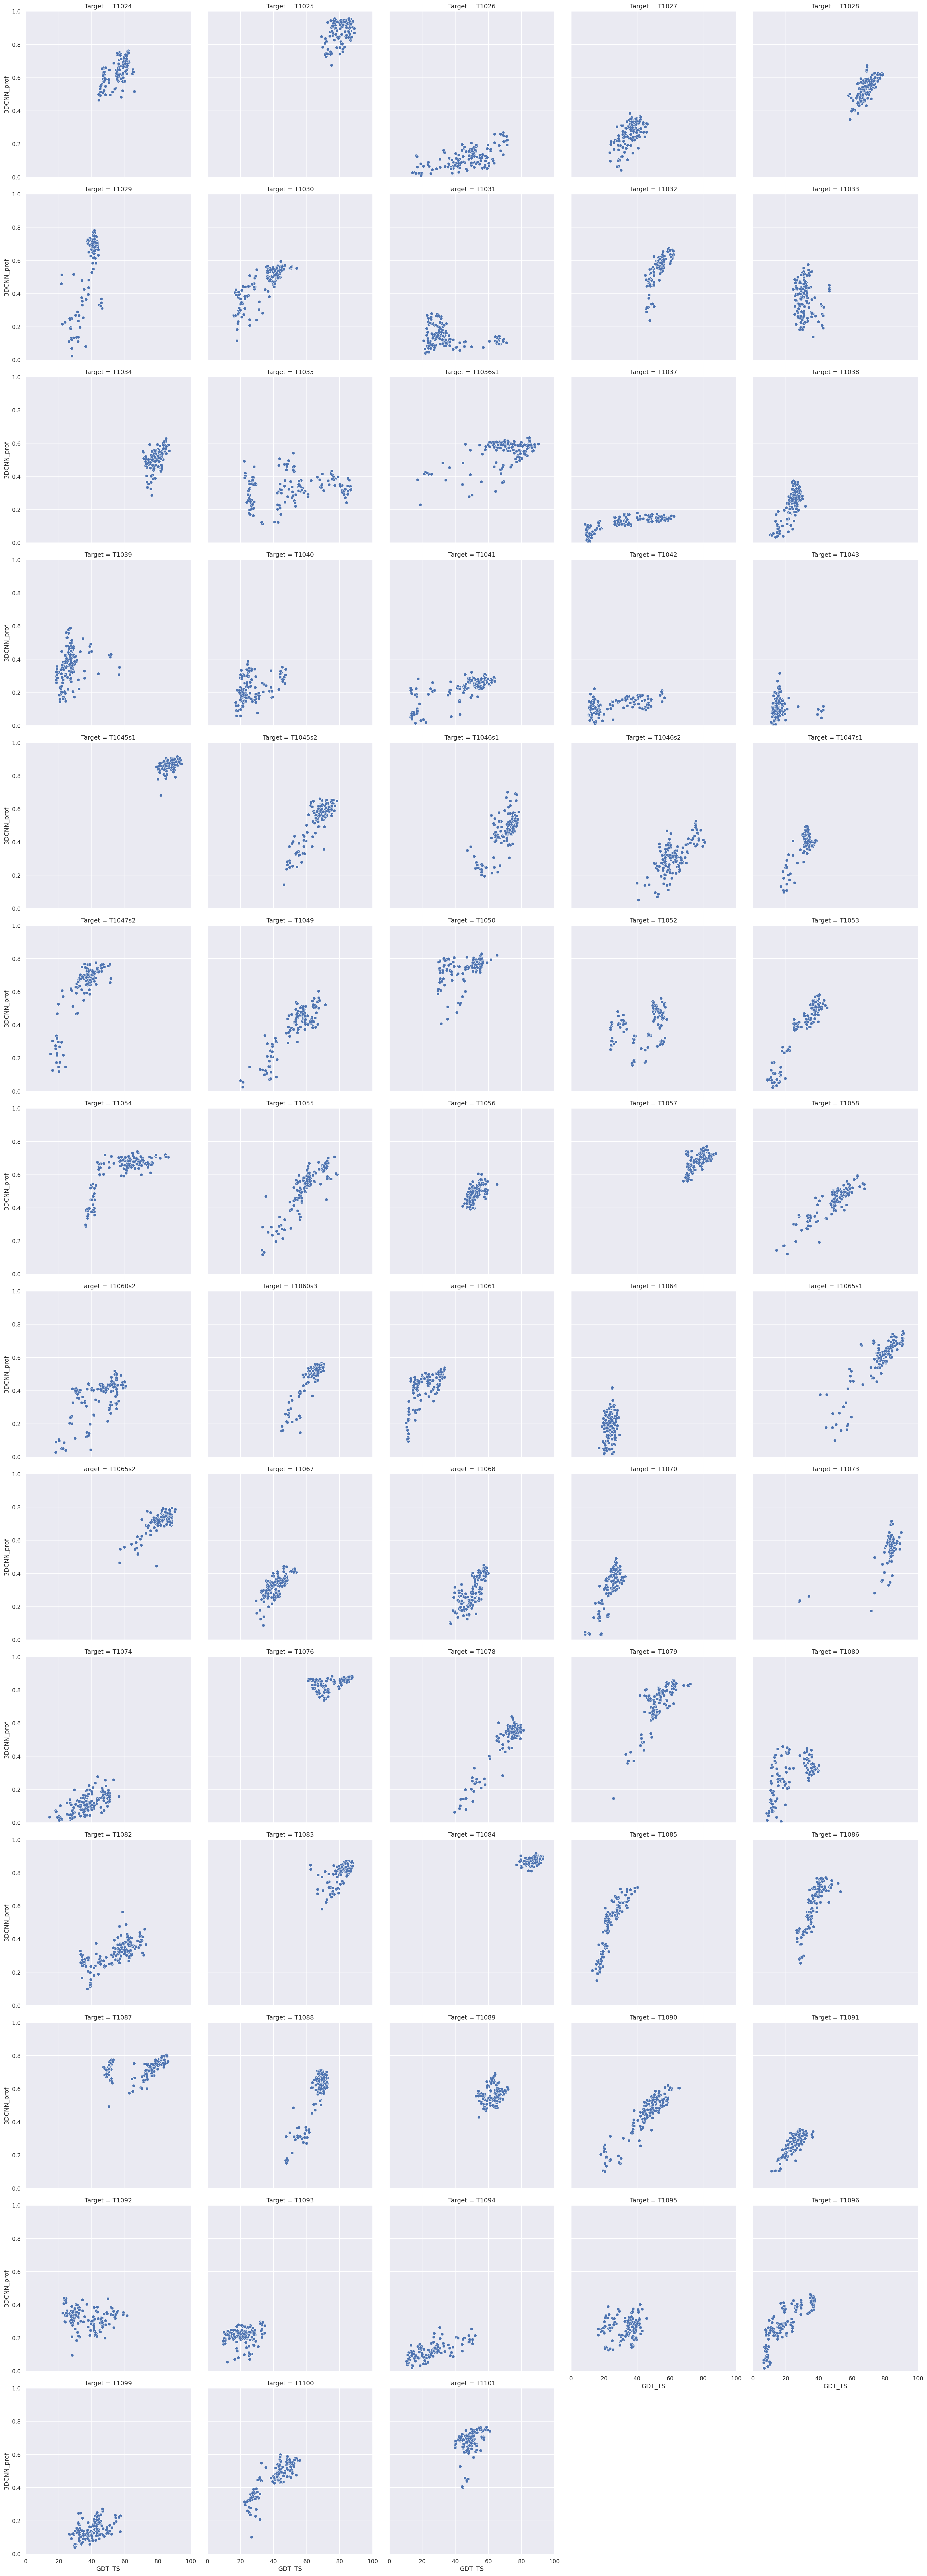

In [31]:
scatter(df, x='GDT_TS', y='3DCNN_prof', col_wrap=5)
plt.savefig('../data/plot/casp14_gdtts_3dcnnprof_scatter.png')